In [ ]:
#!/bin/bash
!curl -L -o daily-climate-time-series-data.zip https://www.kaggle.com/api/v1/datasets/download/sumanthvrao/daily-climate-time-series-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22518  100 22518    0     0  23910      0 --:--:-- --:--:-- --:--:-- 23910


In [ ]:
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


In [ ]:
# Установка необходимых библиотек
!pip install descartes matplotlib pandas statsmodels pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00


In [ ]:
# Для обработки данных
import pandas as pd  # Основной инструмент для работы с данными в табличном формате
import numpy as np  # Библиотека для работы с массивами и математическими операциями

# Визуализация данных
import matplotlib.pyplot as plt  # Основной инструмент для создания графиков
import seaborn as sns  # Инструмент для более удобной визуализации данных, построенный на основе matplotlib
sns.set_style("darkgrid")  # Устанавливаем стиль визуализации
import plotly.express as px  # Интерактивная визуализация данных
from folium.plugins import HeatMap  # Плагин для отображения тепловых карт

# Статистический анализ и модели
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm  # Основной инструмент для статистического анализа и построения моделей
import statsmodels.formula.api as smf  # Форматирование статистических моделей
from statsmodels.stats.diagnostic import het_breuschpagan  # Тест на гетероскедастичность
from statsmodels.stats.multicomp import pairwise_tukeyhsd  # Тест Тьюки для множественных сравнений
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Модель SARIMAX для временных рядов
from statsmodels.tsa.stattools import adfuller  # Тест Дики-Фуллера для проверки стационарности
from statsmodels.tsa.vector_ar.var_model import VAR  # Модель VAR для многомерных временных рядов
from pmdarima import auto_arima

# Моделирование и оценка качества
from sklearn.decomposition import PCA  # Метод главных компонент для уменьшения размерности
from sklearn.cluster import KMeans  # Алгоритм кластеризации K-средних
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Метрики для оценки моделей

# Математические функции
import math  # Математические функции, такие как вычисление квадратных корней


import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera


In [ ]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')

In [ ]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
# Проверка наличия пропусков в данных
missing_values = train.isnull().sum()
print(missing_values)

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [ ]:
# Проверка наличия пропусков в данных
missing_values = test.isnull().sum()
print(missing_values)

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [ ]:
duplicates = train.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')

Количество дубликатов: 0


In [ ]:
def plot_1v1(data, f, s, alpha=0.5, figsize=(10,6)):
  plt.figure(figsize=figsize)
  plt.scatter(train[f], train[s], alpha=alpha)
  plt.title(f'Диаграмма разброса {f} vs {s}')
  plt.xlabel(f'{f}')
  plt.ylabel(f'{s}')
  plt.show()

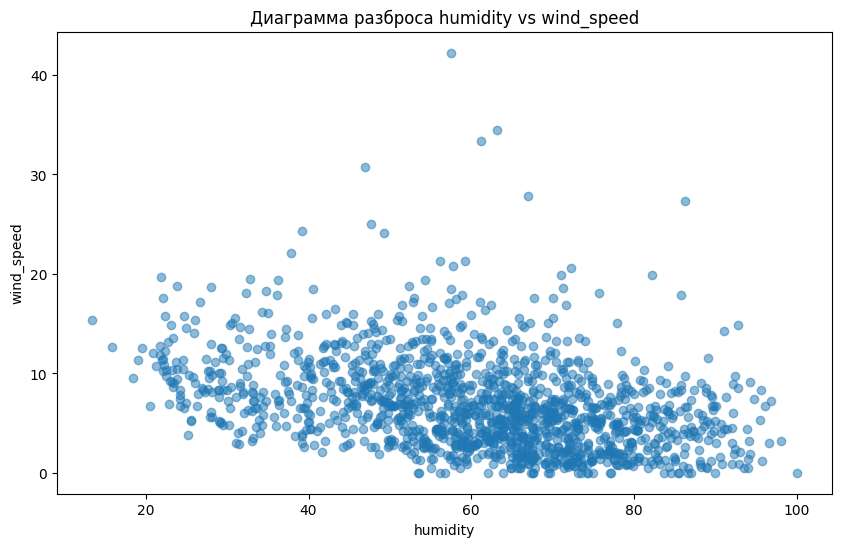

In [ ]:
plot_1v1(train, 'humidity', 'wind_speed')

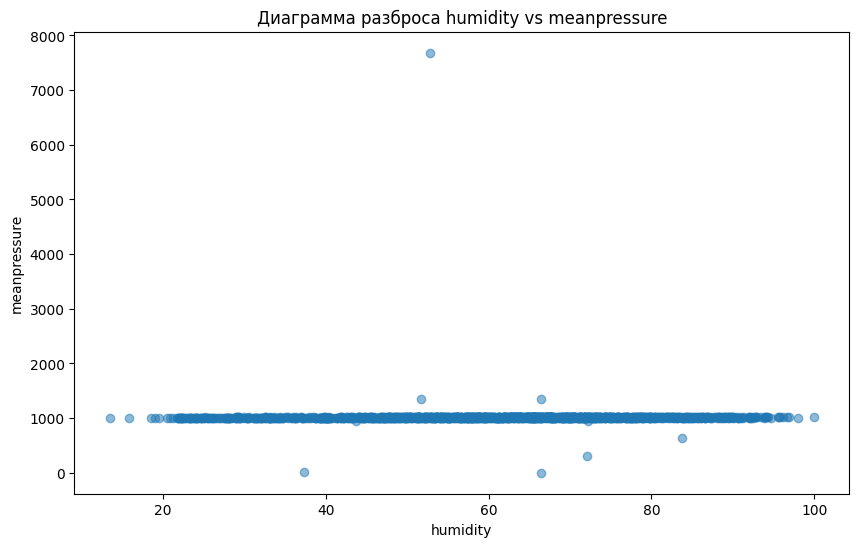

In [ ]:
plot_1v1(train, 'humidity', 'meanpressure')

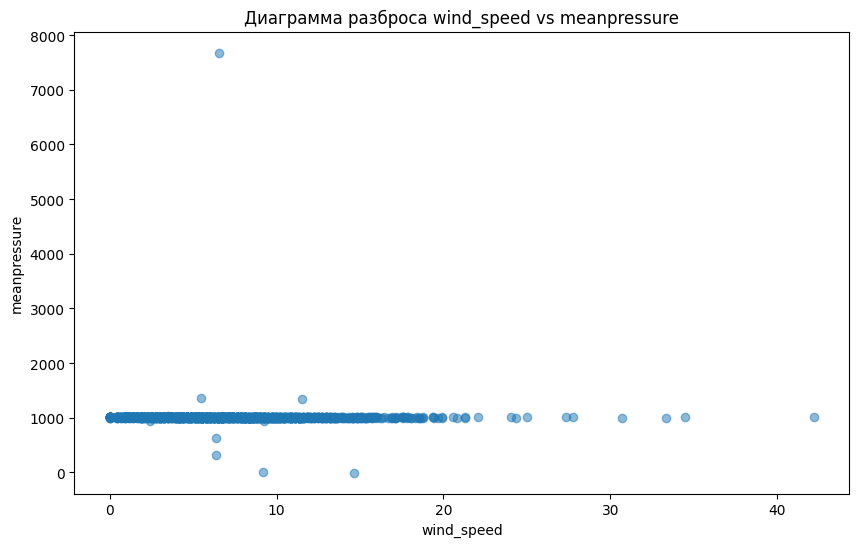

In [ ]:
plot_1v1(train, 'wind_speed', 'meanpressure')

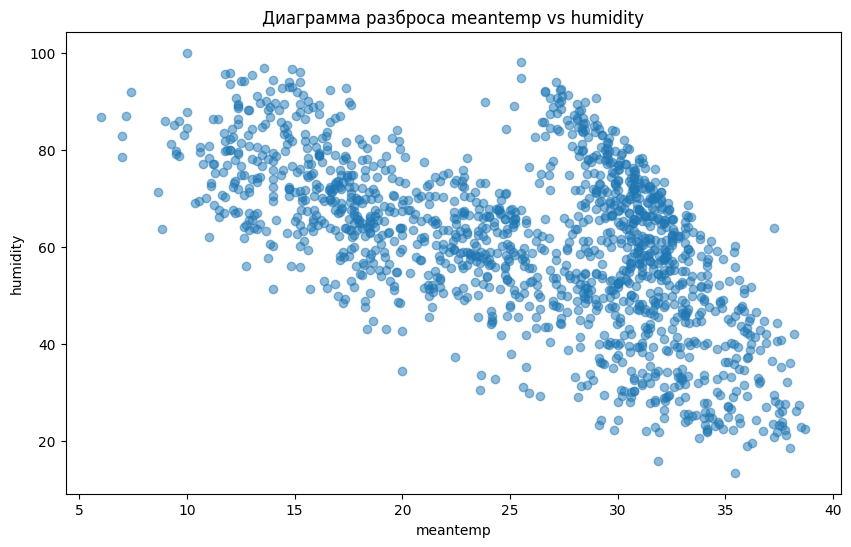

In [ ]:
plot_1v1(train, 'meantemp', 'humidity')

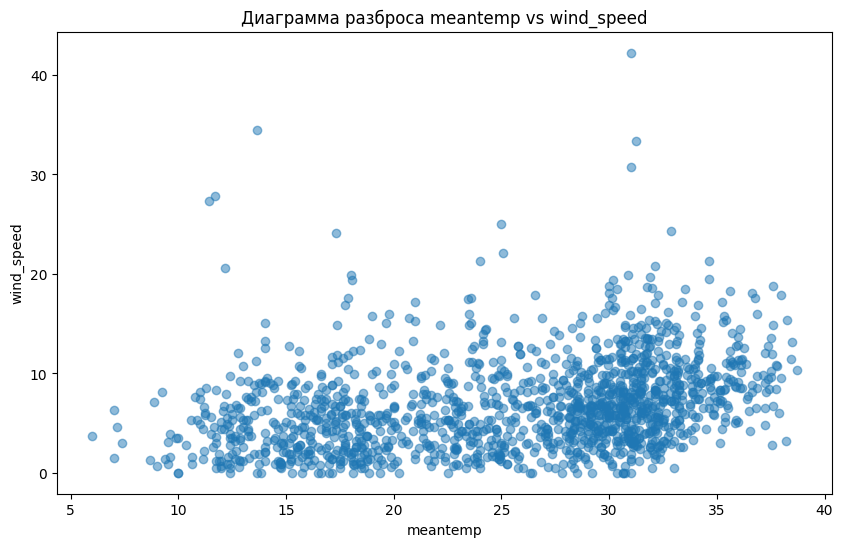

In [ ]:
plot_1v1(train, 'meantemp', 'wind_speed')

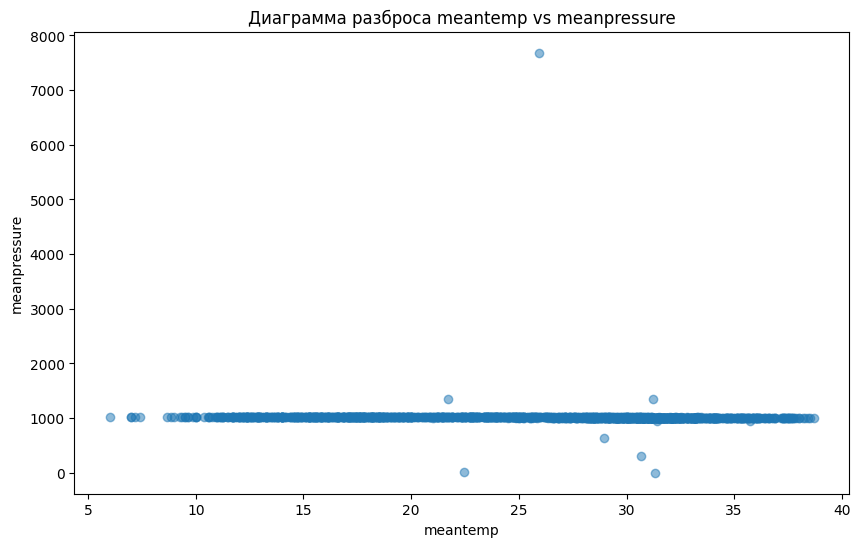

In [ ]:
plot_1v1(train, 'meantemp', 'meanpressure')

In [ ]:
# Вычисление Z-оценки['z_score'] = stats.zscore(df['price'])
train['z_score'] = stats.zscore(train['meanpressure'])
outliers_z = train[train['z_score'].abs() > 3]
print(outliers_z)

# Вычисление межквартильного размаха (IQR)
Q1 = train['meanpressure'].quantile(0.25)
Q3 = train['meanpressure'].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = train[(train['meanpressure'] < (Q1 - 1.5 * IQR)) | (train['meanpressure'] > (Q3 + 1.5 * IQR))]
print(outliers_iqr)

            date   meantemp   humidity  wind_speed  meanpressure    z_score
1182  2016-03-28  25.933333  52.800000    6.546667   7679.333333  37.010757
1309  2016-08-02  30.687500  72.125000    6.375000    310.437500  -3.888921
1323  2016-08-16  31.333333  66.416667   14.666667     -3.041667  -5.628829
1427  2016-11-28  22.454545  37.318182    9.185714     12.045455  -5.545091
            date   meantemp   humidity  wind_speed  meanpressure    z_score
1182  2016-03-28  25.933333  52.800000    6.546667   7679.333333  37.010757
1255  2016-06-09  35.733333  43.733333    9.260000    938.066667  -0.405383
1300  2016-07-24  31.437500  72.250000    2.431250    946.312500  -0.359616
1309  2016-08-02  30.687500  72.125000    6.375000    310.437500  -3.888921
1321  2016-08-14  28.933333  83.700000    6.370000    633.900000  -2.093603
1323  2016-08-16  31.333333  66.416667   14.666667     -3.041667  -5.628829
1362  2016-09-24  31.240000  66.480000    5.496154   1352.615385   1.895492
1416  2016-1

In [ ]:
train_cleaned = train[~train.index.isin(outliers_iqr.index)]

In [ ]:
print(len(train))
print(len(train_cleaned))

1462
1453


In [ ]:
import numpy as np

# Логарифмирование температур
train_cleaned['log_meantemp'] = np.log1p(train_cleaned['meantemp'])
train['log_meantemp'] = np.log1p(train['meantemp'])

<ipython-input-22-89c56c86ba74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['log_meantemp'] = np.log1p(train_cleaned['meantemp'])


In [ ]:
train['date'] = pd.to_datetime(train['date'])
train_cleaned['date'] = pd.to_datetime(train_cleaned['date'])

<ipython-input-29-b1f8386f6c77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['date'] = pd.to_datetime(train_cleaned['date'])


<ipython-input-41-33693ad2c37f>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_meantemp = train['meantemp'].resample('M').mean()
<ipython-input-41-33693ad2c37f>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_meantemp = monthly_meantemp.fillna(method='ffill')  # Заполнение вперед


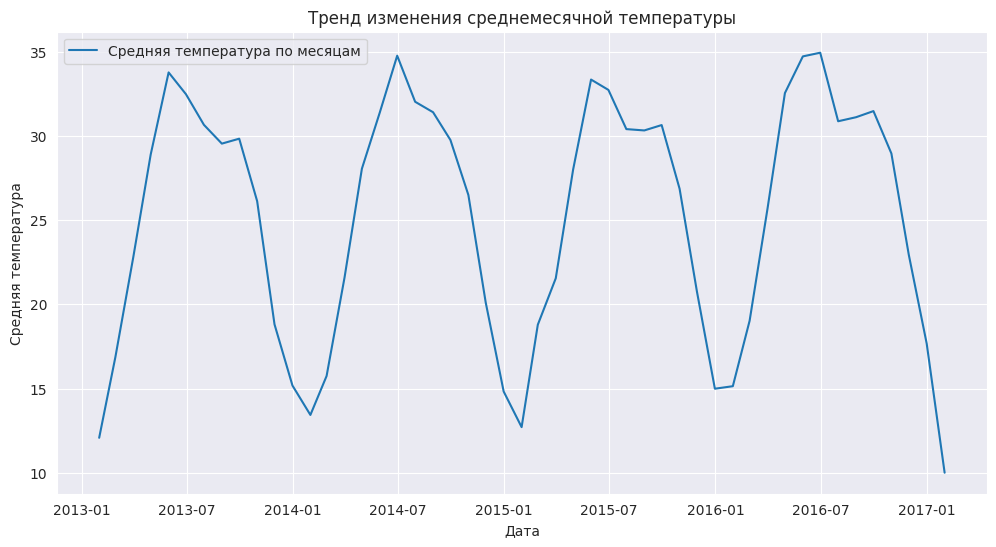

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Преобразуем 'datetime' в индекс
train.set_index('date', inplace=True)

# Группируем данные по месяцам и вычисляем среднюю цену
monthly_meantemp = train['meantemp'].resample('M').mean()

#Заполнение пропусков:
monthly_meantemp = monthly_meantemp.fillna(method='ffill')  # Заполнение вперед

# Построение графика временного ряда
plt.figure(figsize=(12, 6))
plt.plot(monthly_meantemp, label='Средняя температура по месяцам')
plt.title('Тренд изменения среднемесячной температуры')
plt.xlabel('Дата')
plt.ylabel('Средняя температура')
plt.legend()
plt.grid(True)
plt.show()

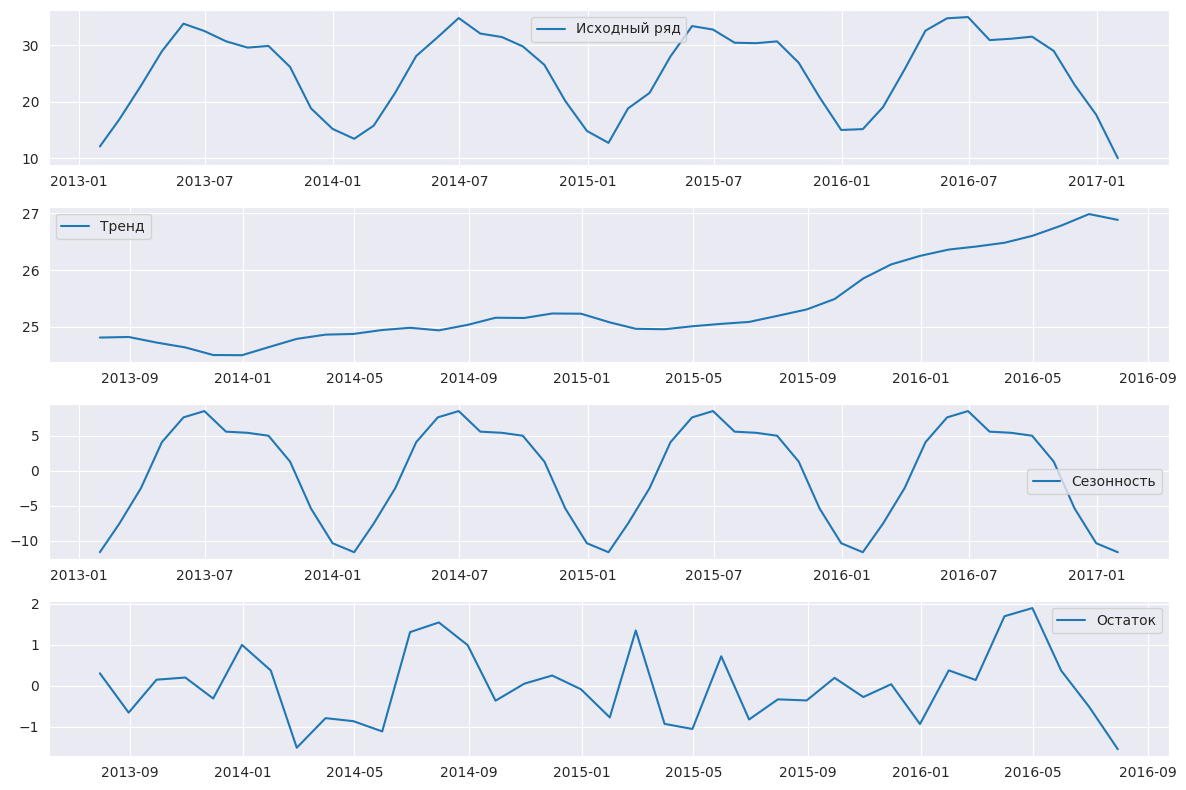

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиция временного ряда
decomposition = seasonal_decompose(monthly_meantemp, model='additive')

# Построение графиков компонентов
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(monthly_meantemp, label='Исходный ряд')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Остаток')
plt.legend()
plt.tight_layout()
plt.show()